**Imports**

In [47]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

conn = sqlite3.connect('/Users/ograndberry/Desktop/berlin_startup_jobs_analysis/bsj_db.db')
c = conn.cursor()

import warnings
warnings.filterwarnings('ignore')

**Open the csv holding information about jobs**

In [2]:
allJobs = pd.read_csv('merged_jobs.csv') #you might need to put the exact location of the file
allJobs.head()

,Unnamed: 0,ID,company_name,date,description,jobtitle,source
0,0,1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,Mobile Engineer for Outdoor Adventure Sports,Berlin Startup Jobs
1,1,2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,Machine Learning,Berlin Startup Jobs
2,2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,Senior Full Stack PHP Developer (f/m),Berlin Startup Jobs
3,3,4,Wayfair,2017-10-02,Your tasks:\n\nKeyword research and competitor...,Jr. Manager SEO UK (Onpage) (m/f),Berlin Startup Jobs
4,4,5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,Data Scientist,Berlin Startup Jobs


# Clean and harmonize job table

**Exclude non tech jobs **

In [3]:
#applied Alina's code to remove non tech jobs
searchfor =['Manager SEO','Salesforce Experte', 'Office Manager', 'Junior Customer Solution', 'Content Management', 'Finance Accountant', 'IT Helpdesk', 'Configuration Manager', 'Distribution Partnerships', 'Digital Marketing Specialist', 'Digital Consultant', 'Quality Assurance Manager', 'Release Manager', 'Strategic Accounts', 'Business Development', 'Physician']
jobTitles = allJobs[~allJobs['jobtitle'].str.contains('|'.join(searchfor))]

In [4]:
#jobTitles = allJobs2[['ID','company_name','data','description','jobtitle','']]
#jobTitles.head()

In [5]:
#tknzr = TweetTokenizer()

**Start the job titles harmonization work  + determine the level of a job (junior, senior ?)**

In [6]:
def cleaner(data):
    a = data.replace('/', ' ')
    b = a.replace('-', ' ')
    #c = re.sub(r'\([^)]*\)', '', b) #remove unnecessary signs
    d = b.split(' at ')[0] #remove 'at google'
    e = d.split(' for ')[0] #remove 'for google'
    z = e.split('-')[0] #remove 'for google'
    f = z.lower().split()
    sw = [x for x in f if x not in stopwords.words('english')] #remove stopwords
    se = ' '.join(map(str, sw))
    return se

def replace_words(data):
    a = data.replace('jr.', 'junior')
    b = a.replace('sr.', 'senior')
    c = b.replace ('ber','')
    d = c.replace ('berlin','')
    e = d.replace ('fullstack','full stack')
    #z = e.lower().split()
    return e

def intern(data): #return true if any of the following keywords are in the job title
    if 'intern' in data:
        return True
    elif 'working student' in data:
        return True
    elif 'internship' in data:
        return True
    elif 'entry-level' in data:
        return True
    elif 'entry level' in data:
        return True
    else:
        return False 

def seniors(data): #return true if any of the following keywords are in the job title
    if 'senior' in data:
        return True
    elif 'head' in data:
        return True
    elif 'lead' in data:
        return True
    elif 'experienced' in data:
        return True
    elif ' vp ' in data:
        return True
    elif ' cto ' in data:
        return True
    elif 'expert' in data:
        return True
    elif 'director' in data:
        return True
    elif ' sr ' in data:
        return True
    else:
        return False 

def juniors(data): #return true if any of the following keywords are in the job title
    if 'junior' in data:
        return True
    elif 'entry-level' in data:
        return True
    elif 'entry level' in data:
        return True
    elif 'graduate' in data:
        return True
    else:
        return False

def intermediate(data): #return true if any of the following keywords are in the job title
    if 'intermediate' in data:
        return True
    elif 'mid level' in data:
        return True
    elif 'mid-level' in data:
        return True
    elif ' mid ' in data:
        return True
    else:
        return False 

def removeSigns(data):
    c = re.sub(r'\([^)]*\)', '', data) #remove unnecessary signs
    return c

**Apply the functions **

In [7]:
jobTitles['NewJobTitles'] = jobTitles['jobtitle'].apply(cleaner)
jobTitles['jobtitle'] = jobTitles['NewJobTitles'].apply(replace_words)
jobTitles['NewJobTitles'] = jobTitles['NewJobTitles'].apply(removeSigns)

In [8]:
jobTitles["Intern"] = jobTitles["jobtitle"].apply(intern)
jobTitles["Junior"] = jobTitles["jobtitle"].apply(juniors)
jobTitles["Intermediate"] = jobTitles["jobtitle"].apply(intermediate)
jobTitles["Senior"] = jobTitles["jobtitle"].apply(seniors)

In [9]:
jobTitles.drop('Unnamed: 0',axis=1, inplace=True)

In [10]:
jobTitles.head()

,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior
0,1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,mobile engineer,Berlin Startup Jobs,mobile engineer,False,False,False,False
1,2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,machine learning,Berlin Startup Jobs,machine learning,False,False,False,False
2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Berlin Startup Jobs,senior full stack php developer,False,False,False,True
4,5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,data scientist,Berlin Startup Jobs,data scientist,False,False,False,False
5,6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Berlin Startup Jobs,full stack developer,False,False,False,False


# Clean and harmonize job titles

**Vectorize the job titles**

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_transformer = count_vect.fit_transform(jobTitles['NewJobTitles'])
bow_transformer.shape

(825, 428)

**Apply TfidfTransformer so that frequent tokens get lower weight**

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(bow_transformer)
X_train_tf = tf_transformer.transform(bow_transformer )
X_train_tf.shape

(825, 428)

**Build the algorithm for clustering the jobs on similarities**

35 is the choosen number of clusters after the application of the elbow method

In [13]:
from sklearn.cluster import KMeans

num_clusters = 35

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_train_tf)

clusters = km.labels_.tolist()

CPU times: user 2.92 s, sys: 32.2 ms, total: 2.95 s
Wall time: 3 s


**Apply the predicted clusters to the 'clusters' column**

In [14]:
jobTitles['clusters'] = clusters

In [15]:
jobTitles.head()

,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior,clusters
0,1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,mobile engineer,Berlin Startup Jobs,mobile engineer,False,False,False,False,27
1,2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,machine learning,Berlin Startup Jobs,machine learning,False,False,False,False,30
2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Berlin Startup Jobs,senior full stack php developer,False,False,False,True,6
4,5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,data scientist,Berlin Startup Jobs,data scientist,False,False,False,False,14
5,6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Berlin Startup Jobs,full stack developer,False,False,False,False,6


**Determine K - Elbow method**

In [16]:
cluster_range = range( 1, 100 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit(X_train_tf)
    cluster_errors.append( clusters.inertia_ )

In [17]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

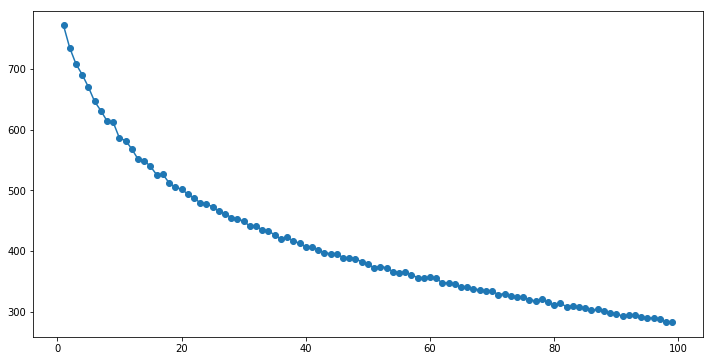

In [18]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

**Save the model results into csv files**

In [19]:
#Cleantitles = pd.DataFrame(jobTitles).to_csv('cleantitles.csv')

In [20]:
positionlevel = pd.DataFrame(jobTitles,columns=['ID','Intern','Junior','Intermediate','Senior']).to_csv('positionlevel.csv')

In [21]:
cleantitles = pd.read_csv('cleantitles.csv')
#cleantitles = cleantitles[['ID','NewJobTitles','clusters']]

In [55]:
positionlevel = pd.read_csv('positionlevel.csv')
positionlevel = positionlevel[['ID','Intern','Junior','Intermediate','Senior']]

In [23]:
cleantitles.head()

,Unnamed: 0,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior,clusters
0,0,1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,mobile engineer,Berlin Startup Jobs,mobile engineer,False,False,False,False,24
1,1,2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,machine learning,Berlin Startup Jobs,machine learning,False,False,False,False,32
2,2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Berlin Startup Jobs,senior full stack php developer,False,False,False,True,2
3,4,5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,data scientist,Berlin Startup Jobs,data scientist,False,False,False,False,33
4,5,6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Berlin Startup Jobs,full stack developer,False,False,False,False,2


**Check the content of the clusters**

In this case we have all the jobs tagged as full stack developer

In [24]:
cleantitles[cleantitles['clusters']==2].head()

,Unnamed: 0,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior,clusters
2,2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Berlin Startup Jobs,senior full stack php developer,False,False,False,True,2
4,5,6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Berlin Startup Jobs,full stack developer,False,False,False,False,2
39,43,44,Caspar Health,2017-10-02,Your duties will cover development and improve...,senior full stack engineer (angular2 + ror),Berlin Startup Jobs,sr. full stack engineer,False,False,False,True,2
46,51,52,Grid Singularity,2017-10-02,About Grid Singularity GmbH:\nGrid Singularity...,senior technical consultant full stack develop...,Berlin Startup Jobs,senior technical consultant full stack develop...,False,False,False,True,2
70,76,77,GoEuro,2017-10-02,About GoEuro\nDriven by our team of over 200 p...,"senior full stack developer (java, react+redux)",Berlin Startup Jobs,senior full stack developer,False,False,False,True,2


**Create a function to replace the cluster number with their final naming**

In [25]:
def finalTitles(data):
    if data == 0:
        return 'other'
    if data == 1:
        return 'Front End Developer'#JavaScript Developer
    if data == 2:
        return 'Full Stack Developer'
    if data == 3:
        return 'DevOps Engineer'
    if data == 4:
        return 'other'
    if data == 5:
        return 'Front End Developer'
    if data == 6:
        return 'Back End Developer/Engineer'#Java Developer
    if data == 7:
        return 'Big Data Engineer'
    if data == 8:
        return 'other'
    if data == 9:
        return 'Big Data Engineer'
    if data == 10:
        return 'QA Engineer'
    if data == 11:
        return 'Back End Developer'#PHP Developer
    if data == 12:
        return 'Business Intelligence'
    if data == 13:
        return 'Back End Developer/Engineer'
    if data == 14:
        return 'other'#a bit mixed, requires a better split 
    if data == 15:
        return 'other'#a bit mixed, requires a better split 
    if data == 16:
        return 'other'#a bit mixed, requires a better split 
    if data == 17:
        return 'System Administrator'
    if data == 18:
        return 'other'#a bit mixed, requires a better split 
    if data == 19:
        return 'Mobile App Developer' #ios developer
    if data == 20:
        return 'Software Engineer' #vp engineering
    if data == 21:
        return 'Ruby Developer' #
    if data == 22:
        return 'Front End Developer' #Android dev
    if data == 23:
        return 'Mobile App Developer' #vp engineering
    if data == 24:
        return 'other' #a bit mixed, requires a better split 
    if data == 25:
        return 'Back End Developer/Engineer' #
    if data == 26:
        return 'Project/Product Manager' #
    if data == 27:
        return 'Back End Developer/Engineer' #SAP HANA dev
    if data == 28:
        return 'Back End Developer/Engineer' #
    if data == 29:
        return 'other' #a bit mixed, requires a better split 
    if data == 30:
        return 'Iot & Embedded Software Engineer' #IOT
    if data == 31:
        return 'other' #a bit mixed, requires a better split 
    if data == 32:
        return 'Machine Learning Engineer' #
    if data == 33:
        return 'Data Scientist' #
    if data == 34:
        return 'Full Stack Developer' #
    
    ###################


In [26]:
cleantitles['CleanTitles'] = cleantitles['clusters'].apply(finalTitles)

In [27]:
cleantitles.head()

,Unnamed: 0,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior,clusters,CleanTitles
0,0,1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,mobile engineer,Berlin Startup Jobs,mobile engineer,False,False,False,False,24,other
1,1,2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,machine learning,Berlin Startup Jobs,machine learning,False,False,False,False,32,Machine Learning Engineer
2,2,3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Berlin Startup Jobs,senior full stack php developer,False,False,False,True,2,Full Stack Developer
3,4,5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,data scientist,Berlin Startup Jobs,data scientist,False,False,False,False,33,Data Scientist
4,5,6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Berlin Startup Jobs,full stack developer,False,False,False,False,2,Full Stack Developer


**Apply tailored functions to job title that couldn't be assigned to a cluster (other) **

In [28]:
def zero(row):
    cluster = 0
    if ('python' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return "Back End Developer/Engineer"
    elif ('scrum' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Scrum Master'
    elif (' iot ' in row['NewJobTitles']) and( row['clusters']== cluster) : 
        return 'Iot & Embedded Software Engineer'
    elif ('softwareentwickler' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Back End Developer/Engineer'
    elif ('entwickler' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Back End Developer/Engineer'
    elif ('daten' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Big Data Engineer'
    elif ('mobile' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Mobile App Developer'
    elif ('blockchain' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return 'Back End Developer/Engineer'
    elif ('technology' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return "CTO/VP - Technology"
    elif ('analytics' in row['NewJobTitles']) and( row['clusters']== cluster) :
        return "Data Scientist"
    else:
        return row['CleanTitles']

def four(row):
    cluster = 4
    app = ['react','app','cross ']
    frontend = ['frontend','node','angular']
    uxui = ['ui']
    dataengineer = ['daten','cloud','data']
    backend = ['software','perl','c#','blockchain','unity','wordpress','php','client','go',
               'kotlin','oracle','python','c++','entwickeln','entwickler','math','docker','java','games','.net','gis','backend']
    for x in app:
        if any (x in row['NewJobTitles'] for x in app)and( row['clusters']== cluster) :
            return "Mobile App Developer"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in uxui:
        if any (x in row['NewJobTitles'] for x in uxui)and( row['clusters']== cluster) :
            return "UX/UI Designer"
    for x in dataengineer:
        if any (x in row['NewJobTitles'] for x in dataengineer)and( row['clusters']== cluster) :
            return "Big Data Engineer"
        else:
            return row['CleanTitles']
        
def eight(row):
    cluster = 8
    app = ['ios','android']
    frontend = ['frontend']
    fullstack = ['fullstack','tech lead','full stack']
    backend = ['software','lead engineer','php','java','backend','ruby','scala','engineering','search']
    projectmanager = ['delivery']
    for x in app:
        if any (x in row['NewJobTitles'] for x in app)and( row['clusters']== cluster) :
            return "Mobile App Developer"
    for x in projectmanager:
        if any (x in row['NewJobTitles'] for x in projectmanager)and( row['clusters']== cluster) :
            return "Project/Product Manager"
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
    for x in fullstack:
        if any (x in row['NewJobTitles'] for x in fullstack )and( row['clusters']== cluster) :
            return "Full Stack Developer"
        else:
            return row['CleanTitles']

def fourteen(row):
    cluster = 14
    devops = ['devops','operation']
    qa = ['qa','test']
    systems = ['systems']
    projectmanager = ['project']
    for x in  devops:
        if any (x in row['NewJobTitles'] for x in  devops)and( row['clusters']== cluster) :
            return "DevOps Engineer"
    for x in projectmanager:
        if any (x in row['NewJobTitles'] for x in projectmanager)and( row['clusters']== cluster) :
            return "Project/Product Manager"
    for x in qa:
        if any (x in row['NewJobTitles'] for x in qa)and( row['clusters']== cluster) :
            return "QA Engineer"
    for x in  systems:
        if any (x in row['NewJobTitles'] for x in  systems)and( row['clusters']== cluster) :
            return "System Administrator"
        else:
            return row['CleanTitles']

def fifteen(row):
    cluster = 15
    fullstack = ['web']
    backend = ['engineer','java','php']
    frontend = ['frontend']
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in  fullstack:
        if any (x in row['NewJobTitles'] for x in  fullstack)and( row['clusters']== cluster) :
            return "Full Stack Developer"
        else:
            return row['CleanTitles']
        
def sixteen(row):
    cluster = 16
    backend = ['software']
    frontend = ['frontend','react']
    uiux = ['ui']
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in uiux:
        if any (x in row['NewJobTitles'] for x in uiux)and( row['clusters']== cluster) :
            return "UX/UI Designer"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
        else:
            return row['CleanTitles']

def eighteen(row):
    cluster = 18
    backend = ['software','rails']
    frontend = ['frontend','react', 'javascript']
    devops = ['devops']
    system = ['specialist','system']
    for x in devops:
        if any (x in row['NewJobTitles'] for x in devops)and( row['clusters']== cluster) :
            return "DevOps Engineer"
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in system :
        if any (x in row['NewJobTitles'] for x in system )and( row['clusters']== cluster) :
            return "System Administrator"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
        else:
            return row['CleanTitles']
        
def twenty4(row):
    cluster = 24
    mobile = ['mobile','growth']
    qa = ['quality assurance','test']
    backend = ['software','engineer','backend','c++','scientif','engine','technik','looking']
    frontend = ['frontend','react', 'javascript','fe', 'work']
    agile = ['agile']
    system = ['informatik','system']
    cto = ['cto']
    bi = ['excel']
    iot = ['robot']
    Dataengineer = ['daten','cloud','data','aws']
    for x in mobile:
        if any (x in row['NewJobTitles'] for x in mobile)and( row['clusters']== cluster) :
            return "Mobile App Developer"
    for x in qa:
        if any (x in row['NewJobTitles'] for x in qa)and( row['clusters']== cluster) :
            return "QA Engineer"
    for x in frontend:
        if any (x in row['NewJobTitles'] for x in frontend)and( row['clusters']== cluster) :
            return "Front End Developer"
    for x in system :
        if any (x in row['NewJobTitles'] for x in system )and( row['clusters']== cluster) :
            return "System Administrator"
    for x in agile :
        if any (x in row['NewJobTitles'] for x in agile )and( row['clusters']== cluster) :
            return "Scrum/Agile Master"
    for x in Dataengineer  :
        if any (x in row['NewJobTitles'] for x in Dataengineer)and( row['clusters']== cluster) :
            return "Big Data Engineer"
    for x in cto  :
        if any (x in row['NewJobTitles'] for x in cto)and( row['clusters']== cluster) :
            return "CTO/VP - Technology"
    for x in bi  :
        if any (x in row['NewJobTitles'] for x in bi)and( row['clusters']== cluster) :
            return "Business Intelligence"
    for x in iot  :
        if any (x in row['NewJobTitles'] for x in iot)and( row['clusters']== cluster) :
            return "Iot & Embedded Software Engineer" 
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
        else:
            return row['CleanTitles']

def twenty9(row):
    cluster = 29
    backend = ['software','java','architect']
    iot = ['iot']
    ai = ['ai']
    Dataengineer = ['database','cloud','data','aws']
    mobile = ['mobile']
    for x in Dataengineer:
        if any (x in row['NewJobTitles'] for x in Dataengineer)and( row['clusters']== cluster) :
            return "Big Data Engineer"
    for x in mobile:
        if any (x in row['NewJobTitles'] for x in mobile)and( row['clusters']== cluster) :
            return "Mobile App Developer"
    for x in iot :
        if any (x in row['NewJobTitles'] for x in iot )and( row['clusters']== cluster) :
            return "Iot & Embedded Software Engineer"
    for x in ai :
        if any (x in row['NewJobTitles'] for x in ai )and( row['clusters']== cluster) :
            return "Machine Learning Engineer"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
        else:
            return row['CleanTitles']
        
def thirty1(row):
    cluster = 31
    backend = ['engineer']
    Datascience = ['data']
    for x in Datascience :
        if any (x in row['NewJobTitles'] for x in Datascience )and( row['clusters']== cluster) :
            return "Data Scientist"
    for x in backend:
        if any (x in row['NewJobTitles'] for x in backend)and( row['clusters']== cluster) :
            return "Back End Developer/Engineer"
        else:
            return row['CleanTitles']
#(x in str for x in a)

In [29]:
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(zero, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(four, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(eight, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(fourteen, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(fifteen, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(sixteen, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(eighteen, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(twenty4, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(twenty9, axis = 1)
cleantitles.loc[:, 'CleanTitles'] = cleantitles.apply(thirty1, axis = 1)

**All job titles have been cleaned and renamed!**

In [30]:
cleantitles[cleantitles['CleanTitles']=='other']

,Unnamed: 0,ID,company_name,date,description,jobtitle,source,NewJobTitles,Intern,Junior,Intermediate,Senior,clusters,CleanTitles


**Final tables printing**

In [50]:
dfclean = cleantitles[['ID','company_name','date','description','jobtitle','CleanTitles','source']]

In [51]:
dfclean = dfclean.set_index('ID')
dfclean.head()## initial job table but with clean job titles 'CleanTitles'

,company_name,date,description,jobtitle,CleanTitles,source
ID,,,,,,
1,Fatmap,2017-10-02,Role & Responsibility: \n\nYou’ll be building ...,mobile engineer,Mobile App Developer,Berlin Startup Jobs
2,AI Engine,2017-10-02,AI Engine is developing innovative machine lea...,machine learning,Machine Learning Engineer,Berlin Startup Jobs
3,November,2017-10-02,Your mission:\n\nDevelopment of a scalable sof...,senior full stack php developer (f m),Full Stack Developer,Berlin Startup Jobs
5,CrossEngage,2017-10-02,About CrossEngage\nCrossEngage is a cloud-base...,data scientist,Data Scientist,Berlin Startup Jobs
6,Ruum,2017-10-02,If you’re passionate about learning new techno...,full stack developer,Full Stack Developer,Berlin Startup Jobs


In [52]:
#dfclean = pd.DataFrame(dfclean).to_csv('dfclean.csv')

In [56]:
positionlevel = positionlevel.set_index('ID') #position level 
positionlevel.head()

,Intern,Junior,Intermediate,Senior
ID,,,,
1,False,False,False,False
2,False,False,False,False
3,False,False,False,True
5,False,False,False,False
6,False,False,False,False


In [54]:
dfclean.to_sql('AllJobs', conn, if_exists='replace')
positionlevel.to_sql('Level', conn, if_exists='replace')